In [1]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import numpy as np
import warnings 
warnings.filterwarnings("ignore")

import ddsp
import ddsp.training

import librosa, librosa.display #display explicitly, bug https://github.com/librosa/librosa/issues/343
import IPython.display as ipd # for playing audio in jupyter notebook

import tensorflow as tf
print(tf.__version__)
tf.compat.v1.enable_v2_behavior()
DEFAULT_SAMPLE_RATE = 16000
sample_rate = DEFAULT_SAMPLE_RATE

2.1.0


In [2]:
# local imports
from importlib import reload
from my_ddsp_utils import *

tf version:  2.1.0


### Make additive synth (ddsp tutorial 0)

In [3]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size

# Create a synthesizer object.
additive_synth = ddsp.synths.Additive(n_samples=n_samples,
                                      sample_rate=sample_rate,
                                      name='additive_synth')

### Generate some arbitrary inputs

(amplitudes, harmonic_distribution, f0_hz

In [5]:
# Amplitude [batch, n_frames, 1].
# Make amplitude linearly decay over time.
amplitudes = np.linspace(1.0, -3.0, n_frames)
amplitudes = amplitudes[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
# Make harmonics decrease linearly with frequency.
n_harmonics = 30
harmonic_distribution = (np.linspace(-2.0, 2.0, n_frames)[:, np.newaxis] + 
                         np.linspace(3.0, -3.0, n_harmonics)[np.newaxis, :])
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 440.0 * np.ones([1, n_frames, 1], dtype=np.float32)

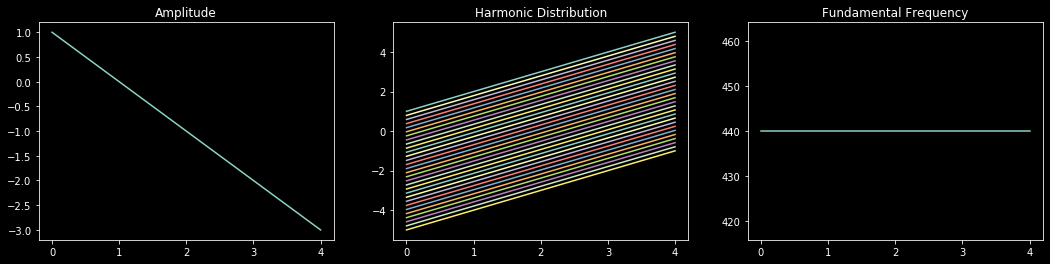

In [6]:
plotControls(amplitudes, harmonic_distribution, f0_hz)

Consider the plots above as outputs of a neural network. These outputs violate the synthesizer's expectations:
* Amplitude is not >= 0 (avoids phase shifts)
* Harmonic distribution is not normalized (factorizes timbre and amplitude)
* Fundamental frequency * n_harmonics > nyquist frequency (440 * 20 > 8000), which will lead to [aliasing](https://en.wikipedia.org/wiki/Aliasing).



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
dict_keys(['amplitudes', 'harmonic_distribution', 'f0_hz'])


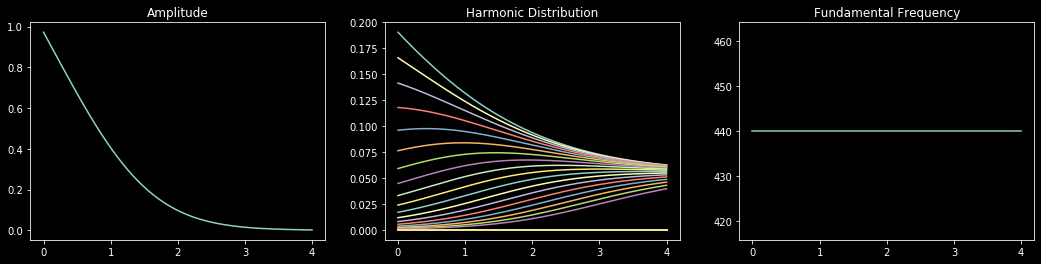

In [7]:
# scale them and plot again
controls = additive_synth.get_controls(amplitudes, harmonic_distribution, f0_hz)
plotControls(**controls)
print(controls.keys())


In [8]:
controls['amplitudes'].shape, controls['harmonic_distribution'].shape, controls['f0_hz'].shape

(TensorShape([1, 1000, 1]), TensorShape([1, 1000, 30]), (1, 1000, 1))

Notice that 
* Amplitudes are now all positive
* The harmonic distribution sums to 1.0
* All harmonics that are above the Nyquist frequency now have an amplitude of 0.

### Synthesize audio with additive synth

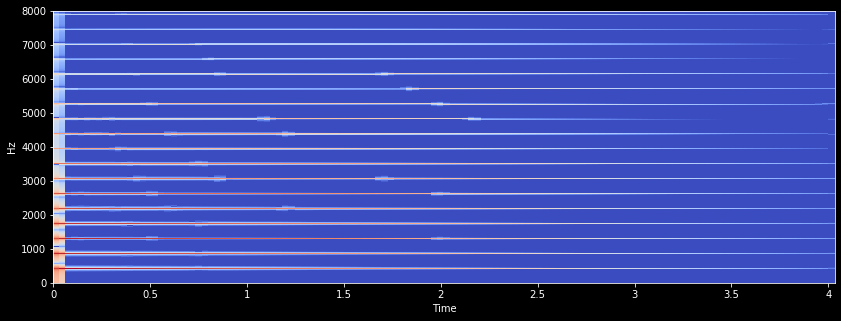

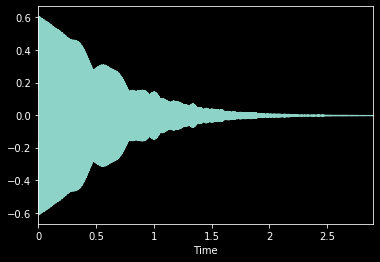

In [9]:
audio = additive_synth.get_signal(**controls)
specPlot(audio)
wavePlot(audio)
play(audio)